##NN_lab1
---
###IO24, 2408
###Доліцой Михайло

In [115]:
# imports
import torch
from torch import nn
from torch.utils.data import TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt

# setup the device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [116]:
mode = int(input("Choose profile: "))

Choose profile: 2


In [117]:
# create the data
n = 10
x = []
y = []

for i in range(2**n):
    binary_str = format(i, f"0{n}b")
    bits = []

    for char in binary_str:
        bits.append(int(char))

    x.append(bits)

x = torch.tensor(x, dtype=torch.float)

for row in x.int():
    xor_result = np.bitwise_xor.reduce(row.numpy())

    y.append([int(xor_result)])

y = torch.tensor(y, dtype=torch.float)

print(x.shape, y.shape, x[:4], y[:4])

torch.Size([1024, 10]) torch.Size([1024, 1]) tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]]) tensor([[0.],
        [1.],
        [1.],
        [0.]])


In [118]:
# train/test split (90/10)
if mode == 2:
    train_size = int(0.9 * len(x))

    x_train, y_train = x[:train_size], y[:train_size]
    x_test, y_test = x[train_size:], y[train_size:]

    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

torch.Size([921, 10]) torch.Size([921, 1]) torch.Size([103, 10]) torch.Size([103, 1])


In [119]:
# create the model
class XORNet(nn.Module):
    def __init__(self):
        super(XORNet, self).__init__()
        self.layer1 = nn.Linear(n, 32)
        self.activation1 =nn.Tanh()
        self.layer2 = nn.Linear(32, 16)
        self.activation2 = nn.Tanh()
        self.layer3 = nn.Linear(16, 1)
        self.activation3 = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation1(x)
        x = self.layer2(x)
        x = self.activation2(x)
        x = self.layer3(x)
        x = self.activation3(x)
        return x

In [120]:
torch.manual_seed(0)

# init the model
model = XORNet()

# setup the optimizer and loss function
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

In [121]:
# train/test loop
epoch = 6000

epoch_count = []
loss_values = []
test_loss_values = []

if mode == 1:
    for epoch in range(epoch):
        model.train()
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            epoch_count.append(epoch)
            loss_values.append(loss)
            model.eval()
            with torch.inference_mode():
                test_pred = model(x)
                test_loss = loss_fn(test_pred, y)
                test_loss_values.append(test_loss)
            print(f"Epoch: {epoch} | Test: {loss} | Test loss: {test_loss}")

if mode == 2:
    for epoch in range(epoch):
        model.train()
        optimizer.zero_grad()
        y_pred = model(x_train)
        loss = loss_fn(y_pred, y_train)
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            epoch_count.append(epoch)
            loss_values.append(loss)
            model.eval()
            with torch.inference_mode():
                test_pred = model(x_test)
                test_loss = loss_fn(test_pred, y_test)
                test_loss_values.append(test_loss)
            print(f"Epoch: {epoch} | Test: {loss} | Test loss: {test_loss}")

Epoch: 0 | Test: 0.25326165556907654 | Test loss: 0.27571168541908264
Epoch: 500 | Test: 0.03577710688114166 | Test loss: 0.09598220884799957
Epoch: 1000 | Test: 0.006626276299357414 | Test loss: 0.0439085029065609
Epoch: 1500 | Test: 0.005792099051177502 | Test loss: 0.039114054292440414
Epoch: 2000 | Test: 0.005733142606914043 | Test loss: 0.03885802626609802
Epoch: 2500 | Test: 0.005712551064789295 | Test loss: 0.03881675750017166
Epoch: 3000 | Test: 0.005702105816453695 | Test loss: 0.03880546987056732
Epoch: 3500 | Test: 0.005695969797670841 | Test loss: 0.03880077227950096
Epoch: 4000 | Test: 0.005692057311534882 | Test loss: 0.038798172026872635
Epoch: 4500 | Test: 0.00568942679092288 | Test loss: 0.038796525448560715
Epoch: 5000 | Test: 0.005687589291483164 | Test loss: 0.038795407861471176
Epoch: 5500 | Test: 0.0056862724013626575 | Test loss: 0.038794633001089096


In [122]:
test_pred[-5:].round(), y_test[-5:]

(tensor([[1.],
         [0.],
         [1.],
         [1.],
         [0.]]),
 tensor([[1.],
         [0.],
         [1.],
         [1.],
         [0.]]))

Text(0, 0.5, 'Loss')

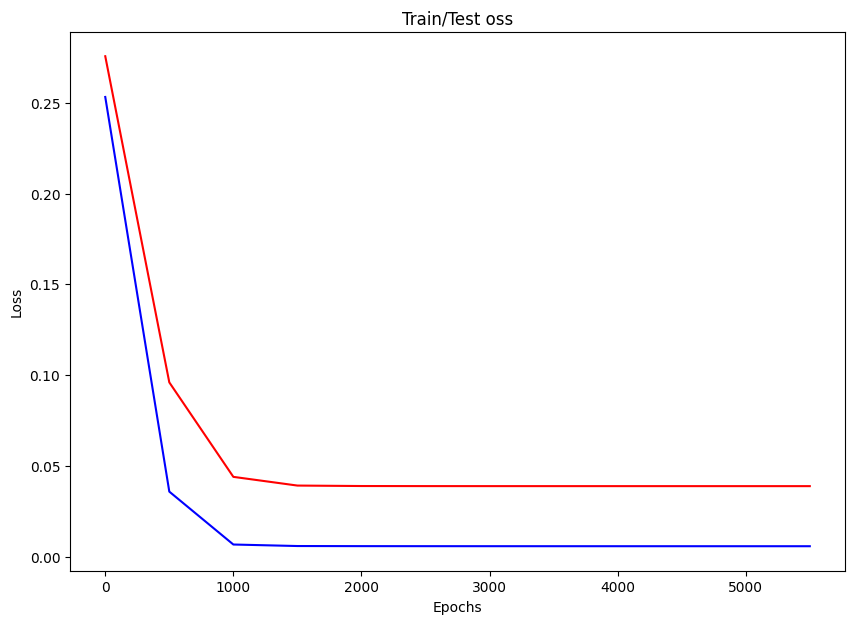

In [123]:
# plot the losses
plt.figure(figsize=(10, 7))
plt.plot(epoch_count, torch.tensor(loss_values).numpy(), c="b", label="Train loss")
plt.plot(epoch_count, torch.tensor(test_loss_values).numpy(), c="r", label="Test loss")
plt.title("Train/Test oss")
plt.xlabel("Epochs")
plt.ylabel("Loss")